H3. Агрегация выплат по неделям и обучение рекрентной нейронной сети повысист точность предсказания за счет анализа скрытых закономерностей

1. Loading and preparing data...

2. Aggregating data by week...

5. Training LSTM model...
Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - loss: 0.7526 - val_loss: 0.5537 - learning_rate: 0.0010
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4502 - val_loss: 0.2029 - learning_rate: 0.0010
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1360 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0265 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0612 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0056 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0204 - val_loss: 0.0328 - learning_rate: 0.0010
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0184 - val_loss: 0.0072 - learning_rate: 0.0010
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40m

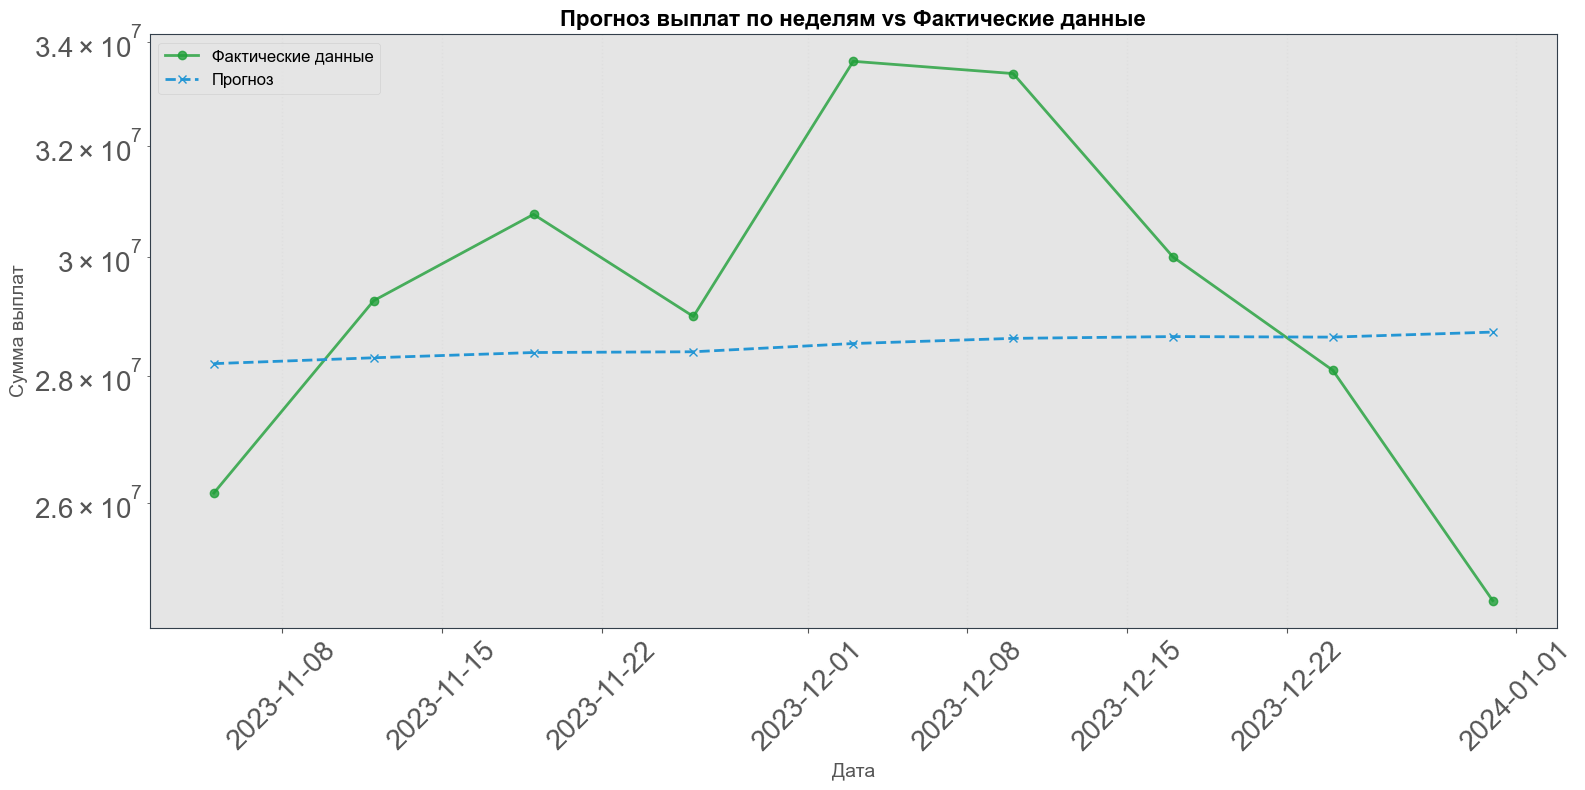


Метрики теста:
MAE: 2430879.25
MSE: 8787237679188.90
RMSE: 2964327.53
MAPE: 8.18%

Генерация прогноза на 1 год (52 недели)...
Сгенерирован прогноз для 12/52 недель
Сгенерирован прогноз для 24/52 недель
Сгенерирован прогноз для 36/52 недель
Сгенерирован прогноз для 48/52 недель


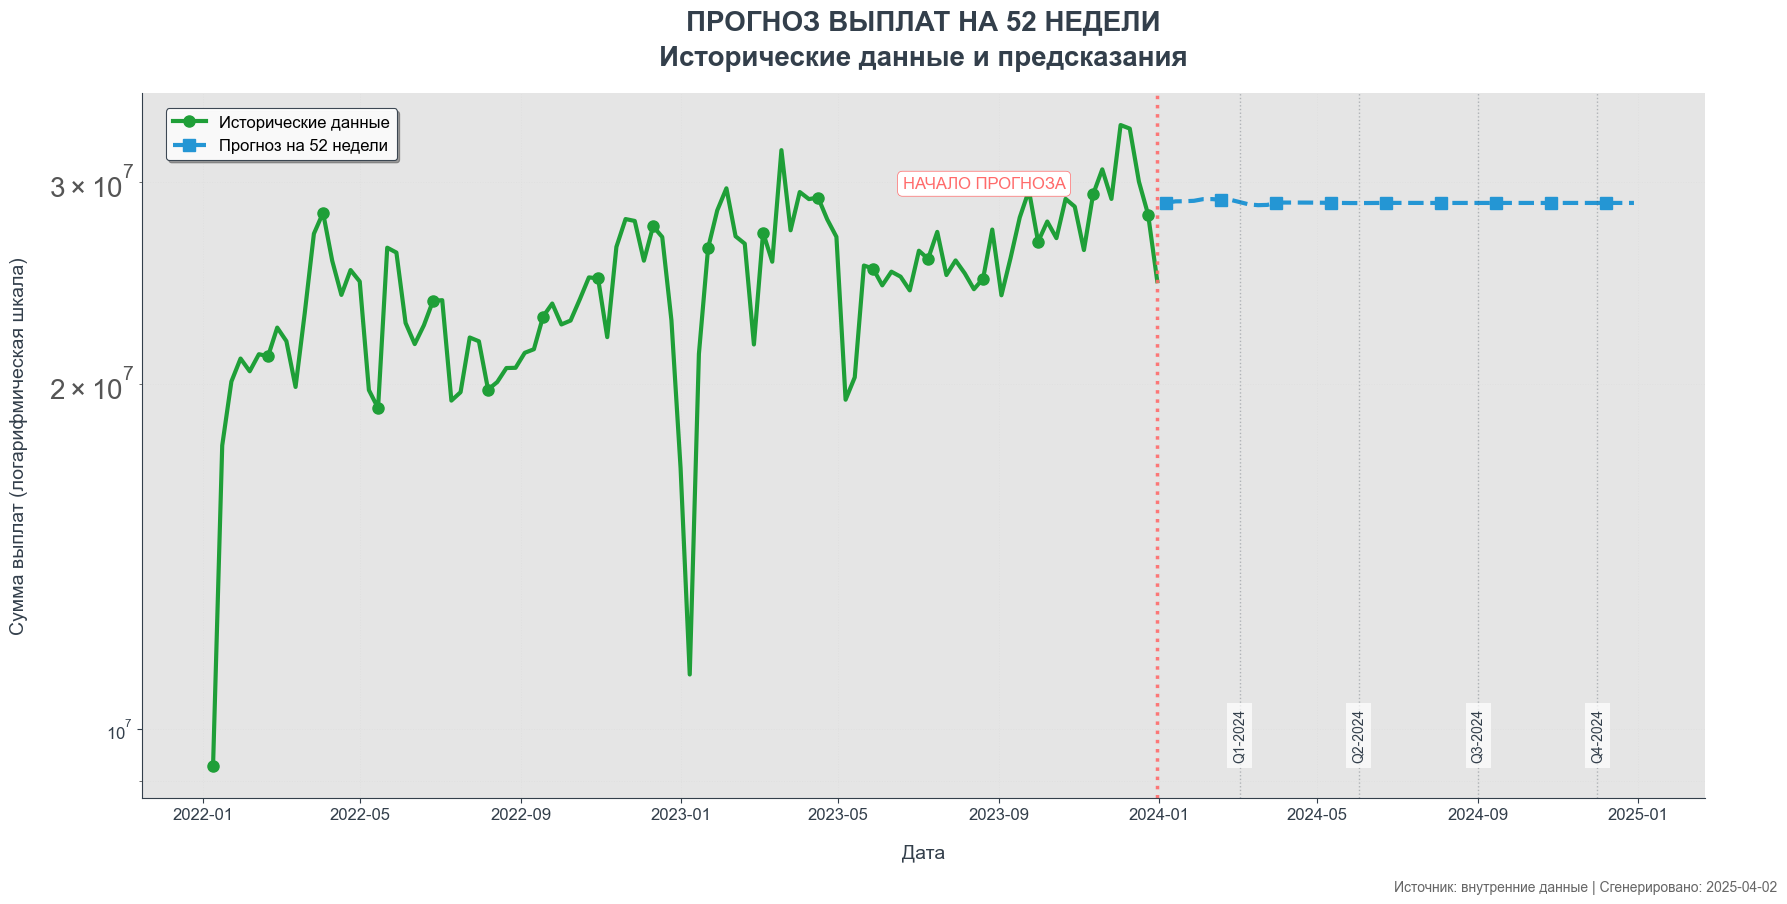


Quarterly Forecast Summary:
                      sum        mean            std
year quarter                                        
2024 Q1       374643072.0  28818698.0  121385.184479
     Q2       373856896.0  28758222.0   10709.064773
     Q3       373773632.0  28751818.0     632.204892
     Q4       373769664.0  28751512.0      28.019224

Detailed 52-week forecast saved to 'lstm_52week_forecast.csv'


In [14]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load and prepare data
print("1. Loading and preparing data...")
data = pd.read_csv(r"D:\repositories\cup_it_25\CupIT_Sber_data.csv", delimiter=";", decimal=',')

data['service_amount_net'] = pd.to_numeric(data['service_amount_net'], errors='coerce')
data['service_date'] = pd.to_datetime(data['service_date'])
data = data.dropna(subset=['service_date', 'service_amount_net'])

# 2. Aggregate by WEEK and apply log transform
print("\n2. Aggregating data by week...")
weekly_data = data.resample('W', on='service_date')['service_amount_net'].sum().to_frame('total_payments')
weekly_data = weekly_data[weekly_data['total_payments'] > 0]
weekly_data['log_payments'] = np.log(weekly_data['total_payments'])

# 3. Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
weekly_data['scaled_payments'] = scaler.fit_transform(weekly_data[['log_payments']])

# 4. Prepare data for LSTM
def create_sequences(data, seq_length=12):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Using 12 weeks (about 3 months) as sequence length
seq_length = 12
train_size = int(len(weekly_data) * 0.8)
train_data = weekly_data.iloc[:train_size]['scaled_payments'].values
test_data = weekly_data.iloc[train_size:]['scaled_payments'].values

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# 5. Build and train LSTM model (enhanced for longer forecasts)
print("\n5. Training LSTM model...")
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Add early stopping and learning rate reduction
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 6. Make predictions
print("\n6. Making predictions...")
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Визуализация результатов
plt.figure(figsize=(16, 8))

# Фактические данные
plt.plot(weekly_data.index[train_size+seq_length:], np.exp(actual), 
         label='Фактические данные', color='#1F9F38', marker='o', markersize=6, alpha=0.8, linewidth=2)

# Предсказанные данные
plt.plot(weekly_data.index[train_size+seq_length:], np.exp(predictions), 
         label='Прогноз', color='#2496D4', linestyle='--', marker='x', markersize=6, linewidth=2)

plt.title('Прогноз выплат по неделям vs Фактические данные', fontsize=16, fontweight='bold')
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Сумма выплат', fontsize=14)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(rotation=45)
plt.yscale('log')
plt.tight_layout()
plt.show()

# 8. Вычисление метрик
mae = mean_absolute_error(np.exp(actual), np.exp(predictions))
mse = mean_squared_error(np.exp(actual), np.exp(predictions))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.exp(actual) - np.exp(predictions)) / np.exp(actual))) * 100

print("\nМетрики теста:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# 9. Прогноз на 1 год (52 недели)
print("\nГенерация прогноза на 1 год (52 недели)...")
future_steps = 52
future_predictions = []
current_input = test_data[-seq_length:].tolist()

for i in range(future_steps):
    input_seq = np.array(current_input[-seq_length:]).reshape(1, seq_length, 1)
    next_pred = model.predict(input_seq, verbose=0)[0, 0]
    future_predictions.append(next_pred)
    current_input.append(next_pred)
    if (i+1) % 12 == 0:
        print(f"Сгенерирован прогноз для {i+1}/{future_steps} недель")

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 10. Профессиональная визуализация прогноза (исправленная версия)
plt.figure(figsize=(18, 9), facecolor='white')

# Настраиваем стиль (используем доступные стили)
available_styles = plt.style.available
if 'seaborn' in available_styles:
    plt.style.use('seaborn')
else:
    plt.style.use('ggplot')  # альтернативный стиль

# Основные параметры оформления
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['grid.color'] = '#DDDDDD'
plt.rcParams['grid.alpha'] = 0.5

# Исторические данные (последние 2 года)
history_dates = weekly_data.index[-104:]
history_values = np.exp(weekly_data['log_payments'].values[-104:])

# Прогнозные данные
forecast_dates = pd.date_range(start=weekly_data.index[-1] + pd.Timedelta(weeks=1), 
                              periods=future_steps, freq='W')
forecast_values = np.exp(future_predictions).flatten()

# 1. Основной график с историей и прогнозом
main_plot = plt.plot(history_dates, history_values, 
                    label='Исторические данные', 
                    color='#1F9F38', linewidth=3, 
                    marker='o', markersize=8, markevery=6)

forecast_plot = plt.plot(forecast_dates, forecast_values, 
                        label='Прогноз на 52 недели', 
                        color='#2496D4', linewidth=3, 
                        linestyle='--', marker='s', markersize=8, markevery=6)

# 2. Яркая граница между историей и прогнозом
boundary_line = plt.axvline(x=history_dates[-1], color='#FF6B6B', linestyle=':', linewidth=2.5, alpha=0.9)
plt.text(history_dates[-1] - pd.Timedelta(weeks=10), plt.ylim()[1]*0.85, 
         'НАЧАЛО ПРОГНОЗА', fontsize=12, color='#FF6B6B', ha='right', 
         bbox=dict(facecolor='white', edgecolor='#FF6B6B', boxstyle='round,pad=0.3'))

# 3. Квартальные разделители с подписями
for qdate in forecast_dates[(forecast_dates.month % 3 == 0) & (forecast_dates.day < 7)]:
    plt.axvline(x=qdate, color='#333F4B', linestyle=':', linewidth=1, alpha=0.3)
    quarter_label = f"Q{qdate.quarter}-{qdate.year}"
    plt.text(qdate, plt.ylim()[0] + (plt.ylim()[1]-plt.ylim()[0])*0.05, quarter_label, 
             fontsize=10, color='#333F4B', ha='center', rotation=90, 
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# 4. Заголовок и подписи осей
plt.title('ПРОГНОЗ ВЫПЛАТ НА 52 НЕДЕЛИ\nИсторические данные и предсказания', 
          fontsize=20, fontweight='bold', pad=20, color='#333F4B', linespacing=1.5)
plt.xlabel('Дата', fontsize=14, labelpad=15, color='#333F4B')
plt.ylabel('Сумма выплат (логарифмическая шкала)', fontsize=14, labelpad=15, color='#333F4B')

# 5. Легенда с тенью
legend = plt.legend(frameon=True, fontsize=12, loc='upper left',
                   facecolor='white', edgecolor='#333F4B', shadow=True,
                   bbox_to_anchor=(0.01, 0.99), framealpha=0.95)
legend.get_frame().set_linewidth(0.8)

# 6. Логарифмическая шкала с улучшенной сеткой
plt.yscale('log')
plt.grid(True, which="both", ls=":", linewidth=0.7, alpha=0.6)

# 7. Настройка осей
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12, colors='#333F4B')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#333F4B')

# 8. Подпись источника и даты создания
plt.text(0.99, 0.01, f'Источник: внутренние данные | Сгенерировано: {pd.Timestamp.now().strftime("%Y-%m-%d")}', 
         transform=plt.gcf().transFigure, 
         ha='right', va='bottom', color='#666666', fontsize=10)

# 9. Автоматическое выравнивание и отступы
plt.tight_layout()
plt.subplots_adjust(top=0.9, right=0.95)

plt.show()


# 11. Save detailed forecast
forecast_df = pd.DataFrame({
    'date': forecast_dates,
    'forecast_amount': np.exp(future_predictions).flatten(),
    'log_forecast': future_predictions.flatten()
})

# Add month and quarter information
forecast_df['month'] = forecast_df['date'].dt.month_name()
forecast_df['quarter'] = 'Q' + forecast_df['date'].dt.quarter.astype(str)
forecast_df['year'] = forecast_df['date'].dt.year

# Calculate quarterly aggregates
quarterly_forecast = forecast_df.groupby(['year', 'quarter'])['forecast_amount'].agg(['sum', 'mean', 'std'])
print("\nQuarterly Forecast Summary:")
print(quarterly_forecast)

forecast_df.to_csv('lstm_52week_forecast.csv', index=False)
print("\nDetailed 52-week forecast saved to 'lstm_52week_forecast.csv'")

**Вывод:** Гипотеза не оправдалась, сглаживание характерное для данной архитектуры не позволяет эффективно учитывать сезонность и тренды на временном промежутке следующего года


Тест Льюнга-Бокса для остатков LSTM модели:
     lb_stat  lb_pvalue
1   1.234337   0.266565
2   1.324287   0.515745
3   2.514187   0.472733
4   6.582920   0.159640
5   7.260595   0.201970
6   7.745700   0.257332
7   7.924589   0.339291
8  12.390056   0.134631

Значение p-value: 0.1346

Вывод: p-value > 0.05 → Нет оснований отвергать нулевую гипотезу.
Остатки модели не демонстрируют значимой автокорреляции, что свидетельствует
об адекватности модели и хорошем учете временной структуры данных.


<Figure size 1200x500 with 0 Axes>

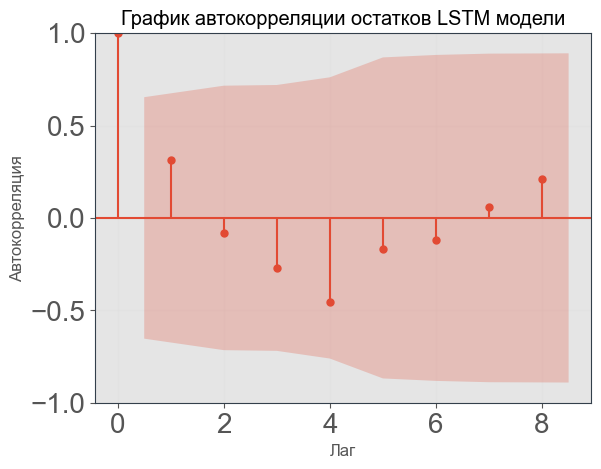

In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# 1. Получение остатков модели
residuals = np.exp(actual).flatten() - np.exp(predictions).flatten()

# 2. Автоматический подбор максимального количества лагов
max_possible_lags = min(10, len(residuals) - 1)  # Не больше 10 и не больше len(residuals)-1

# 3. Тест Льюнга-Бокса
if max_possible_lags > 0:
    print("\nТест Льюнга-Бокса для остатков LSTM модели:")
    lb_test = acorr_ljungbox(residuals, lags=max_possible_lags, return_df=True)
    print(lb_test)
    
    # 4. Анализ p-value
    p_value = lb_test['lb_pvalue'].iloc[-1]
    print(f"\nЗначение p-value: {p_value:.4f}")
    
    # 5. Интерпретация результатов
    if p_value > 0.05:
        print("\nВывод: p-value > 0.05 → Нет оснований отвергать нулевую гипотезу.")
        print("Остатки модели не демонстрируют значимой автокорреляции, что свидетельствует")
        print("об адекватности модели и хорошем учете временной структуры данных.")
    else:
        print("\nВывод: p-value ≤ 0.05 → Отвергаем нулевую гипотезу.")
        print("Остатки содержат значимую автокорреляцию, что указывает на:")
        print("- Неучтенные временные зависимости")
        print("- Возможное несоответствие архитектуры модели")
        print("- Необходимость дополнительной настройки модели")
        
    # 6. Визуализация автокорреляции остатков
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(12, 5))
    plot_acf(residuals, lags=max_possible_lags, alpha=0.05)
    plt.title('График автокорреляции остатков LSTM модели')
    plt.xlabel('Лаг')
    plt.ylabel('Автокорреляция')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("\nНедостаточно данных для выполнения теста Льюнга-Бокса (требуется минимум 2 наблюдения).")